In [1]:
# Import necessary libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

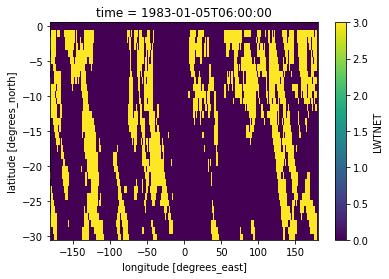

In [55]:
test = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_3/LWTNET_1983.nc')
test.isel(time = 17).LWTNET.plot()


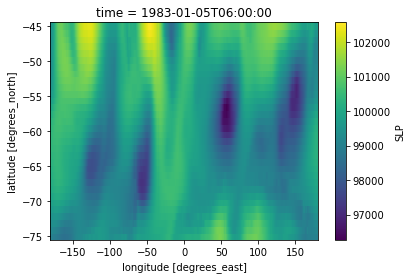

In [67]:
test = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_3/SLP_1983.nc')
test.isel(time = 17).SLP.plot()

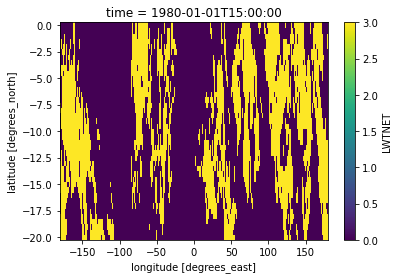

In [41]:
test = test.sel(lat = slice(-20,0)).LWTNET
test = xr.where(test<220,3,0)
test.plot()

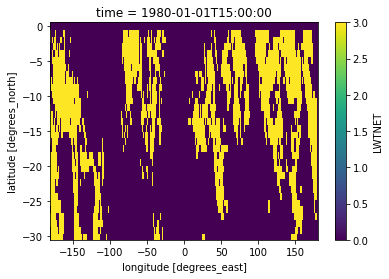

In [40]:
test2 = test.interp(lat = np.linspace(-30,0, 32), lon = np.linspace(-180,180, 256))
test2 = xr.where(test2<220,3,0)
test2.LWTNET.plot()

In [34]:
test2

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 5)
Coordinates:
    time     datetime64[ns] 1980-01-01T15:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -20.0 -15.0 -10.0 -5.0 0.0
Data variables:
    LWTNET   (lat, lon) float64 140.7 132.6 130.5 138.0 ... nan nan nan nan

# Step 1: Run Make_X_data/Make_yrly_data

# 3. after running Make_data.py in parallel

In [ ]:
## For all other variables: use Make_data to get data to scratch, then do the following

In [ ]:
# combine years of data
variable = 'LWTNET'
test = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_3/'+str(variable)+'*')
test = test.load()
test.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/LWTNET.nc')



# 3. feature data - make standardized anomalies

In [33]:
# repeat for each variable - save standardized anomalies
SLP = xr.open_mfdataset(fp +'SLP.nc')

variable = 'SLP'
data = SLP.load()

climo_mean = data.groupby("time.month").mean('time')
climo_std = data.groupby("time.month").std('time')

stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data.groupby("time.month"),
    climo_mean,
    climo_std,
)

stand_anomalies.to_netcdf('/rc_scratch/reba1583/variable_yr_files_4/'+variable)




/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/reba1583/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:

# 4. Compile and format data for training (a, b, c, d)

* not enough memory in notebook - complete step 4 using Make_one_large_dataset.py Make_one_large_dataset.scripte

## a. load in data and put together

In [2]:


fp = '/rc_scratch/reba1583/variable_yr_files_4/'

H = xr.open_mfdataset(fp+'H').H.values
IWV = xr.open_mfdataset(fp+'IWV').IWV.values
EFLUX = xr.open_mfdataset(fp+'EFLUX').EFLUX.values
LWTNET = xr.open_mfdataset(fp+'LWTNET').LWTNET.values
SF = xr.open_mfdataset(fp+'SF').sf.values
SLP = xr.open_mfdataset(fp+'SLP').SLP.values
T = xr.open_mfdataset(fp+'T').T.values
U = xr.open_mfdataset(fp+'U').U.values
V = xr.open_mfdataset(fp+'V').V.values

In [1]:
del H
del V 
del U
del T
del IWV
del EFLUX
del SF
del SLP
del LWTNET


NameError: name 'H' is not defined

In [2]:
data 

NameError: name 'data' is not defined

## b. 1D labeling - Is there an AR making landfall?

In [4]:
# category 1d label data: is there a landfalling AR or no

centers = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/ML_test_artimes_centers.csv')
centers = centers[pd.to_datetime(centers.AR_time)<pd.to_datetime('2003-01-01')]

ar_times = pd.to_datetime(np.array(centers.AR_time))

times_resampled = []
for i in range(len(ar_times)):
    if ar_times[i].hour in [0,6,12,18]:
        times_resampled.append(ar_times[i])
    else:
        times_resampled.append(ar_times[i] - pd.Timedelta(hours = 3))

ar_times_6hrly = pd.to_datetime(np.unique(times_resampled))
    
times = pd.DataFrame({'time':pd.to_datetime(np.array(variable_times))}).set_index('time')

times['AR_flag'] = np.zeros(len(times))
times.AR_flag[times.index.isin(ar_times_6hrly)] = 1

ar_flag = np.array(times.AR_flag)


NameError: name 'variable_times' is not defined

## c. 2d labeling, AR masks

In [72]:
#resample ar_catalog in time and space, take maximums
ar_catalog = xr.open_mfdataset(['/projects/reba1583/Research2/data/AR_catalogue/2000.nc', '/projects/reba1583/Research2/data/AR_catalogue/2001.nc', '/projects/reba1583/Research2/data/AR_catalogue/2002.nc']).sel(lat =slice(-90,0))
ar_catalog = ar_catalog.resample(time="6H").max()
ar_catalog = ar_catalog.interp(lon = np.arange(-180,181,1), lat = np.arange(-90,1,1))

ar_values = ar_catalog.ar_binary_tag.values
ar_values[np.isnan(ar_values)] = 0
ar_values[ar_values<=.0001] = 0
ar_values[ar_values>.0001] = 1

In [80]:
#make a netcdf with all the times between 2000 and 2003 with AR binary tags filled in 
ar_catalog_times = ar_catalog.time.values
times = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_4/H').time.values
ar_catalog_data = np.zeros((4384, 91,361))

ar_catalog_data[np.searchsorted(times, ar_catalog_times)] = ar_values

ar_ds = xr.DataArray(ar_catalog_data, coords = [times, ar_catalog.lat, ar_catalog.lon], dims = ['time', 'lat', 'lon', ], name='ar_binary_tag')

ar_ds.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ar_ds.nc')

## d. Make one netcdf with all data

In [9]:
var_data = dict(
    features = (['n_channel', 'time', 'lat', 'lon' ], data),
    label_1d_AR = (['time'], ar_flag),
    label_2d_AR = (['time', 'lat', 'lon'], ar_catalog)
)

coords = dict(
    n_channel = (['n_channel'], np.array(['H', 'IWV', 'EFLUX', 'LWTNET', 'SF', 'SLP', 'T', 'U', 'V'])),
    time = (['time'], pd.to_datetime(np.array(variable_times)))
    
)

ds = xr.Dataset(
    data_vars = var_data, 
    coords = coords
)

In [13]:

ds


<xarray.Dataset>
Dimensions:      (n_channel: 9, time: 4384, lat: 91, lon: 361)
Coordinates:
    id           (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * n_channel    (n_channel) <U6 'H' 'IWV' 'EFLUX' 'LWTNET' ... 'T' 'U' 'V'
  * time         (time) datetime64[ns] 2000-01-01 ... 2002-12-31T18:00:00
Dimensions without coordinates: lat, lon
Data variables:
    features     (n_channel, time, lat, lon) float64 5.058e+03 5.058e+03 ... nan
    label_1d_AR  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    label_2d_AR  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [12]:
ds.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/data')

# 5. Plot one timestep of input data and AR Catalog

In [11]:
ds = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/data')

In [17]:
#define function 
def show_sample(ds):
    num_channels = len(ds_sample.n_channel)
    #define figure with 1 row and 5 columns. 
    fig,axes = plt.subplots(num_channels+1,1,figsize=(10, num_channels*5))
    #set the background to white, for some reason its transparent
    fig.set_facecolor('w')
    #choose some colormaps for drawing
    cmaps = ['Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r']
    #loop over features (inputs)
    for i,ax in enumerate(axes[0:num_channels]):
        #plot images
        ax.imshow(ds.isel(n_channel = i).features,cmap=cmaps[i])
        ax.axis('off')
        ax.set_title(ds.n_channel[i].values)

    #plot labels (output) which is AR mask
    ax = axes[num_channels]
    ax.imshow(ds.label_2d_AR[:,:],cmap='magma')
    ax.axis('off')
    ax.set_title('AR_mask')

#     fig.suptitle('class label: {}, n flashes: {}'.format(ds.label_1d_class.values,ds.label_1d_reg.values),y=0.75)

    return ds.label_1d_AR.values

array(1.)

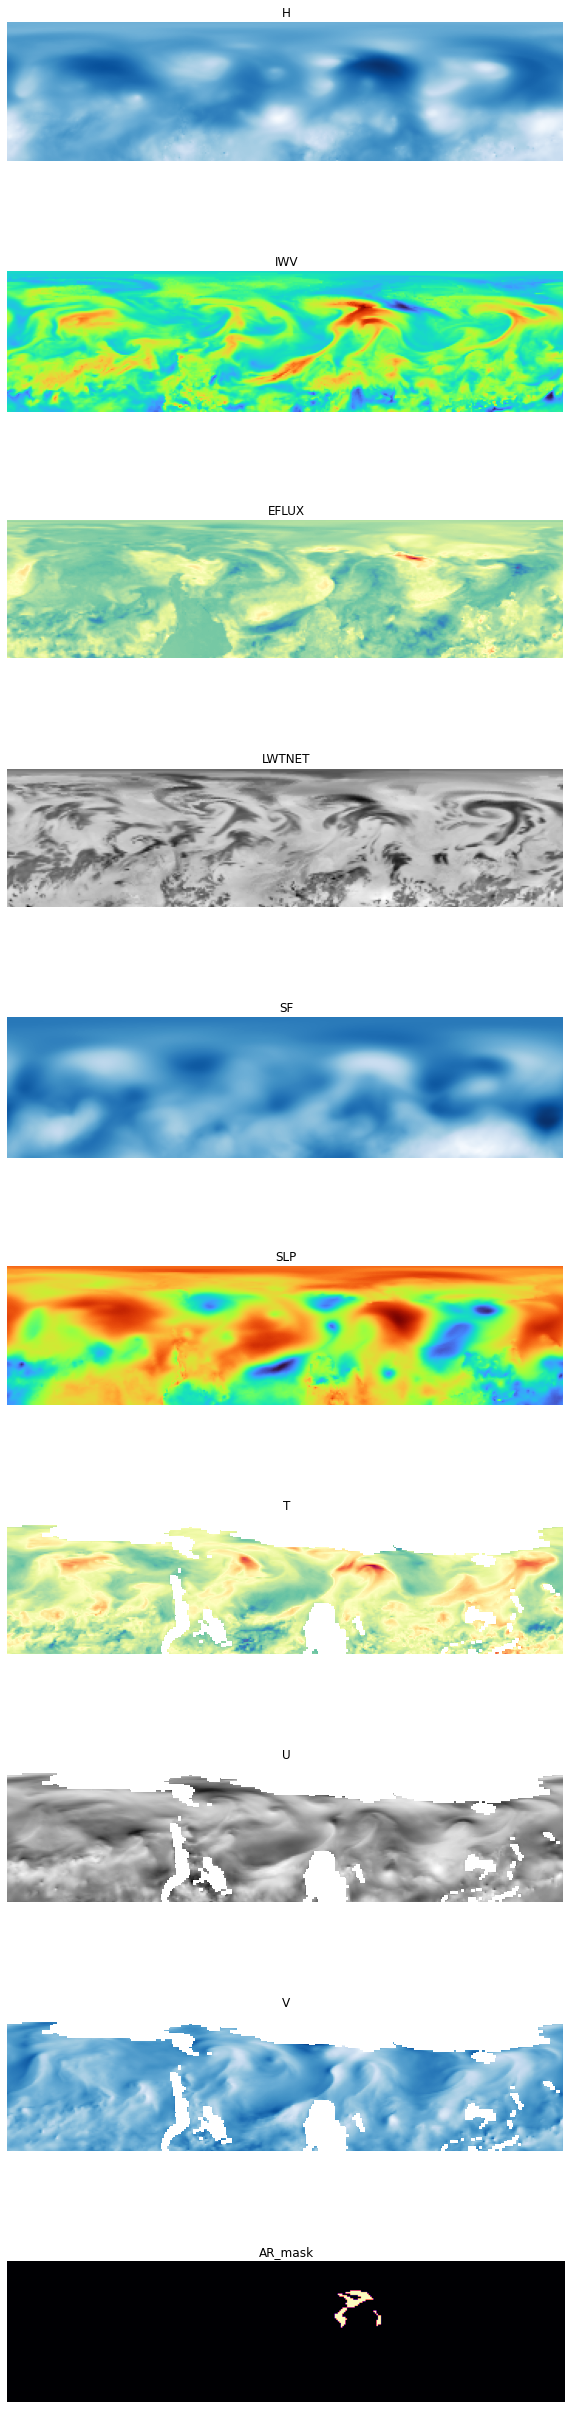

In [19]:
ds_sample = ds.isel(time = 37)
show_sample(ds_sample)

# 5. Get normalized anomalies and Split Data into train and test

In [26]:
ds = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/data')
ds['lon'] = np.arange(-180,181,1)
ds['lat'] = np.arange(-90,1,1)

In [27]:
ds

<xarray.Dataset>
Dimensions:      (n_channel: 9, time: 4384, lat: 91, lon: 361)
Coordinates:
  * n_channel    (n_channel) object 'H' 'IWV' 'EFLUX' 'LWTNET' ... 'T' 'U' 'V'
  * time         (time) datetime64[ns] 2000-01-01 ... 2002-12-31T18:00:00
  * lon          (lon) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
  * lat          (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... -6 -5 -4 -3 -2 -1 0
Data variables:
    features     (n_channel, time, lat, lon) float64 ...
    label_1d_AR  (time) float64 ...
    label_2d_AR  (time, lat, lon) float64 ...

In [28]:
index = np.arange(len(ds.time))
split1, split2 = int(.7*len(index)), int(.85*len(index))


np.random.shuffle(index)
index_train, index_validate, index_test = index[:split1], index[split1:split2], index[split2:]
index_train.sort()
index_validate.sort()
index_test.sort()

In [29]:
ds_train = ds.isel(time = index_train)
ds_test = ds.isel(time = index_test)
ds_validate = ds.isel(time = index_validate)

In [30]:
ds_test.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_test')

In [31]:
ds_train.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_train')

In [32]:
ds_validate.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_validate')

# 6 Select data so it is balanced between AR and No AR

* Note: ran this as a script on blanca node super computer because memory was not enough here

In [9]:
ds_train = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_train').transpose('time','lon','lat','n_channel')
ds_val = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_validate').transpose('time','lon','lat','n_channel')
ds_test = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_test').transpose('time','lon','lat','n_channel')


In [59]:
val_num_ARs = len(ds_val.label_1d_AR.values[ds_val.label_1d_AR.values==1])
ds_val_noAR_index = ds_val.label_1d_AR.values
ds_val_noAR_index = np.squeeze(np.where(ds_val_noAR_index==0))
np.random.shuffle(ds_val_noAR_index)
ds_val_noAR_index = ds_val_noAR_index[:val_num_ARs]

ds_val_AR_index = np.squeeze(np.where(ds_val.label_1d_AR.values==1))

validate_select_times = np.sort(np.concatenate((ds_val_noAR_index,ds_val_AR_index)))

ds_val = ds_val.isel(time = validate_select_times)
ds_val.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/trimmed_ds_validate.nc')

In [ ]:
test_num_ARs = len(ds_test.label_1d_AR.values[ds_test.label_1d_AR.values==1])
ds_test_noAR_index = ds_test.label_1d_AR.values
ds_test_noAR_index = np.squeeze(np.where(ds_test_noAR_index==0))
np.random.shuffle(ds_test_noAR_index)
ds_test_noAR_index = ds_test_noAR_index[:test_num_ARs]

ds_test_AR_index = np.squeeze(np.where(ds_test.label_1d_AR.values==1))

test_select_times = np.sort(np.concatenate((ds_test_noAR_index,ds_test_AR_index)))

ds_test = ds_test.isel(time = test_select_times)
ds_test.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/trimmed_ds_test.nc')

In [61]:
train_num_ARs = len(ds_train.label_1d_AR.values[ds_train.label_1d_AR.values==1])
ds_train_noAR_index = ds_train.label_1d_AR.values
ds_train_noAR_index = np.squeeze(np.where(ds_train_noAR_index==0))
np.random.shuffle(ds_train_noAR_index)
ds_train_noAR_index = ds_train_noAR_index[:train_num_ARs]

ds_train_AR_index = np.squeeze(np.where(ds_train.label_1d_AR.values==1))

train_select_times = np.sort(np.concatenate((ds_train_noAR_index,ds_train_AR_index)))

ds_train = ds_train.isel(time = train_select_times)
ds_train.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/trimmed_ds_train.nc')

KeyboardInterrupt: 

# 7 Make modified 1d data for traditional ML methods

In [76]:
#2d input data for neural network algorithms
train_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_train')
data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_validate')
test_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/ds_test')


In [96]:
# repeat for each section of data
data = train_data
name = 'train'

In [102]:
data = data.sel(lat = slice(-90,-40))
ar_binary = data.label_1d_AR.values
ar_area_count = data.label_2d_AR.sum(dim = ('lat','lon')).values

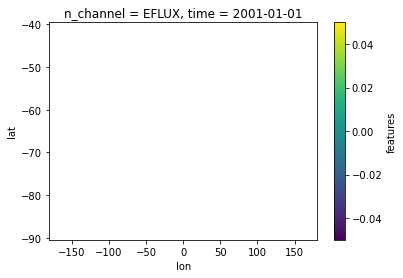

In [107]:
data.isel(n_channel = 2, time = 1020).features.plot()

In [91]:
# Make pandas dataframe with colums q_***_var where *** is the percentile (0, 10, 25, 50, 75, 90, 100) and var is the variable

q_000_data = data.min(dim = ('lat','lon')).features.values
q_010_data = data.quantile(.10, dim = ('lat','lon')).features.values
q_025_data = data.quantile(.25, dim = ('lat','lon')).features.values
q_050_data = data.quantile(.50, dim = ('lat','lon')).features.values
q_075_data = data.quantile(.75, dim = ('lat','lon')).features.values
q_090_data = data.quantile(.90, dim = ('lat','lon')).features.values
q_100_data = data.quantile(1, dim = ('lat','lon')).features.values


In [92]:
d = {'q_000_H': q_000_data[0], 'q_010_H': q_010_data[0], 'q_025_H': q_025_data[0], 'q_050_H': q_050_data[0], 
     'q_075_H': q_075_data[0], 'q_100_H': q_100_data[0], 
     'q_000_IWV': q_000_data[1], 'q_010_IWV': q_010_data[1], 'q_025_IWV': q_025_data[1], 'q_050_IWV': q_050_data[1], 
     'q_075_IWV': q_075_data[1], 'q_100_IWV': q_100_data[1], 
     'q_000_EFLUX': q_000_data[2], 'q_010_EFLUX': q_010_data[2], 'q_025_EFLUX': q_025_data[2], 'q_050_EFLUX': q_050_data[2], 
     'q_075_EFLUX': q_075_data[2], 'q_100_EFLUX': q_100_data[2], 
     'q_000_LWTNET': q_000_data[3], 'q_010_LWTNET': q_010_data[3], 'q_025_LWTNET': q_025_data[3], 'q_050_LWTNET': q_050_data[3], 
     'q_075_LWTNET': q_075_data[3], 'q_100_LWTNET': q_100_data[3], 
     'q_000_SF': q_000_data[4], 'q_010_SF': q_010_data[4], 'q_025_SF': q_025_data[4], 'q_050_SF': q_050_data[4], 
     'q_075_SF': q_075_data[4], 'q_100_SF': q_100_data[4],
     'q_000_SLP': q_000_data[5], 'q_010_SLP': q_010_data[5], 'q_025_SLP': q_025_data[5], 'q_050_SLP': q_050_data[5], 
     'q_075_SLP': q_075_data[5], 'q_100_SLP': q_100_data[5], 
     'q_000_T': q_000_data[6], 'q_010_T': q_010_data[6], 'q_025_T': q_025_data[6], 'q_050_T': q_050_data[6], 
     'q_075_T': q_075_data[6], 'q_100_T': q_100_data[6], 
     'q_000_U': q_000_data[7], 'q_010_U': q_010_data[7], 'q_025_U': q_025_data[7], 'q_050_U': q_050_data[7], 
     'q_075_U': q_075_data[7], 'q_100_U': q_100_data[7], 
     'q_000_V': q_000_data[8], 'q_010_V': q_010_data[8], 'q_025_V': q_025_data[8], 'q_050_V': q_050_data[8], 
     'q_075_V': q_075_data[8], 'q_100_V': q_100_data[8],
     'label_class': ar_binary, 'label_reg': ar_area_count
    
    }
df = pd.DataFrame(data = d)
df

,q_000_H,q_010_H,q_025_H,q_050_H,q_075_H,q_100_H,q_000_IWV,q_010_IWV,q_025_IWV,q_050_IWV,...,q_075_U,q_100_U,q_000_V,q_010_V,q_025_V,q_050_V,q_075_V,q_100_V,label_class,label_reg
0,-3.472125,-1.061429,-0.467247,0.113341,0.826926,1.814349,-1.822937,-1.292311,-0.957931,-0.198959,...,0.687296,2.083353,-4.233574,-1.361344,-0.808094,0.056208,0.769463,2.491618,0.0,0.0
1,-2.680284,-1.379377,-0.748522,-0.098454,0.752224,1.782924,-1.635354,-1.311863,-1.013518,-0.202842,...,0.466800,2.871005,-3.340605,-1.429355,-0.884696,-0.043832,0.911871,2.022429,0.0,0.0
2,-1.701944,-1.072232,-0.734945,-0.453118,0.223040,1.073671,-1.559609,-1.024908,-0.775007,-0.496233,...,0.468167,1.515763,-2.608677,-1.227348,-0.665164,0.015130,0.714294,2.776187,0.0,0.0
3,-2.197215,-0.866847,-0.643251,-0.383295,0.032129,1.139497,-1.663269,-1.150937,-0.791418,-0.457531,...,0.692394,2.305161,-2.991417,-1.211079,-0.636693,0.067049,0.553021,2.595840,0.0,0.0
4,-2.241866,-1.064651,-0.768507,-0.274984,0.141029,1.126601,-1.755197,-1.107412,-0.792271,-0.395951,...,0.543705,1.695119,-2.971090,-1.169297,-0.628967,0.085846,0.531290,2.074136,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,-2.191035,-1.088629,-0.574189,0.098917,0.696760,1.860200,-1.540116,-1.024727,-0.586931,-0.019920,...,0.340356,2.164198,-3.359709,-1.254874,-0.590436,0.034667,0.715962,2.025618,0.0,0.0
654,-2.378286,-1.088666,-0.683082,0.168281,0.742192,1.631531,-1.535666,-0.965579,-0.661110,0.105534,...,0.265218,2.030334,-2.958486,-1.184127,-0.638149,-0.004382,0.800812,1.868005,0.0,0.0
655,-3.026455,-1.305488,-0.437934,0.349611,0.825766,1.252272,-1.972237,-1.106501,-0.696204,0.183234,...,0.826383,2.643316,-2.526538,-1.216464,-0.639049,-0.023687,0.751158,2.161564,0.0,0.0
656,-1.430070,-0.651956,-0.101962,0.386693,0.955861,1.691426,-1.373419,-1.033273,-0.817062,-0.450938,...,0.564381,1.873121,-4.558866,-1.158884,-0.525754,0.074844,0.624612,3.925467,0.0,0.0


In [93]:
df.to_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr_norm_anom/tradML_ds_'+name)